# **SberMarket Competition**

Сервисы доставки еды уже давно перестали быть просто курьерами, которые привозят заказ. Индустрия e-grocery стремительно идет к аккумулированию и использованию больших данных, чтобы знать о своих пользователях больше и предоставлять более качественные и персонализированные услуги. Одним из шагов к такой персонализации может быть разработка модели, которая понимает привычки и нужды пользователя, и, к примеру, может угадать, что и когда пользователь захочет заказать в следующий раз.

Такая модель, будучи разработанной, может принести значительную ценность для клиента - сэкономить время при сборке корзины, помочь ничего не забыть в заказе, убрать необходимость планировать закупки и следить за заканчивающимися запасами продуктов.

В данном соревновании участникам предлагается решить задачу предсказания следующего заказа пользователя (безотносительно конкретного момента времени, когда этот заказ произойдет). Заказ пользователя состоит из списка уникальных категорий товаров, вне зависимости от того, сколько продуктов каждой категории он взял.


Импортируем все необходимые библиотеки.
Для анализа и подготовки данных понадобятся Numpy и Pandas. 
Для предикта будем использовать модель LightFM. При обучении на вход этой модели подается разреженная матрица, поэтому необходима функция coo_matrix из библиотеки scipy.

In [1]:
import numpy as np
import pandas as pd 
import time
import os
from lightfm import LightFM
from lightfm.evaluation import auc_score
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse import coo_matrix

import warnings                                  
warnings.filterwarnings('ignore')

/opt/anaconda3/lib/python3.8/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


Импортируем данные:

In [2]:
path_train = os.path.join('..','data','train.csv')
path_submit = os.path.join('..','data','sample_submission.csv')

In [3]:
df = pd.read_csv(path_train, parse_dates=['order_completed_at'])
submit_df = pd.read_csv(path_submit)

В качестве тренировочных данных представляется датасет с историей заказов 20000 пользователей вплоть до даты отсечки, которая разделяет тренировочные и тестовые данные по времени.

train.csv:
user_id - уникальный id пользователя
order_completed_at - дата заказа
cart - список уникальных категорий (category_id), из которых состоял заказ
В качестве прогноза необходимо для каждой пары пользователь-категория из примера сабмита вернуть 1, если категория будет присутствовать в следующем заказе пользователя, или 0 в ином случае. Список категорий для каждого пользователя примере сабмита - это все категории, которые он когда-либо заказывал.

In [4]:
df.head()

,user_id,order_completed_at,cart
0,2,2015-03-22 09:25:46,399
1,2,2015-03-22 09:25:46,14
2,2,2015-03-22 09:25:46,198
3,2,2015-03-22 09:25:46,88
4,2,2015-03-22 09:25:46,157


В сабмите 2 колонки: в первой находится комбинация ид юзера и категории товара, во второй должно быть число 1 или 0, в зависимости от того будет этот товар куплен или нет.sample_submission.csv:
Пример сабмита. В тест входят не все пользователи из тренировочных данных, так как некоторые из них так ничего и не заказали после даты отсечки.

id - идентификатор строки - состоит из user_id и category_id, разделенных точкой с запятой: f'{user_id};{category_id}'. Из-за особенностей проверяющей системы Kaggle InClass, использовать колонки user_id, category_id в качестве индекса отдельно невозможно
target - 1 или 0 - будет ли данная категория присутствовать в следующем заказе пользователя

In [5]:
submit_df.head()

,id,target
0,0;133,0
1,0;5,1
2,0;10,0
3,0;396,1
4,0;14,0


Посмотрим, какие есть юзеры и категории товаров:

In [6]:
# в тренировочном датафрейме количество юзеров следущее:
print('Kоличество юзеров в тренировочном датафрейме', df.user_id.nunique())
# в сабмите:
users = []
carts = []
for row in submit_df.id.values:
    user, cart = row.split(';')
    users.append(int(user))
    carts.append(int(cart))

print('Kоличество юзеров в сабмит датафрейме', len(set(users)))

Kоличество юзеров в тренировочном датафрейме 20000
Kоличество юзеров в сабмит датафрейме 13036


In [7]:
print('Уникальных категорий товаров в тренировочной таблице', df.cart.nunique())
# Находятся они в диапазоне
print('Диапазон категорий в тренировочной таблице', df.cart.min(), ';', df.cart.max())
# Сделаем то же и для сабмит файла
print('Уникальных категорий товаров в сабмите', len(set(carts)))
# Находятся они в диапазоне
print('Диапазон категорий в сабмите', min(carts), ';', max(carts))
# категорий для предсказания меньше в сабмит файле

Уникальных категорий товаров в тренировочной таблице 881
Диапазон категорий в тренировочной таблице 0 ; 880
Уникальных категорий товаров в сабмите 858
Диапазон категорий в сабмите 0 ; 880


In [8]:
user_order_counts = df.groupby('user_id').agg({'order_completed_at':'count'}).values
print('Минимальное количество заказов клиента', user_order_counts.min()) 
print('Максимальное количество заказов клиента', user_order_counts.max())

Минимальное количество заказов клиента 3
Максимальное количество заказов клиента 3508


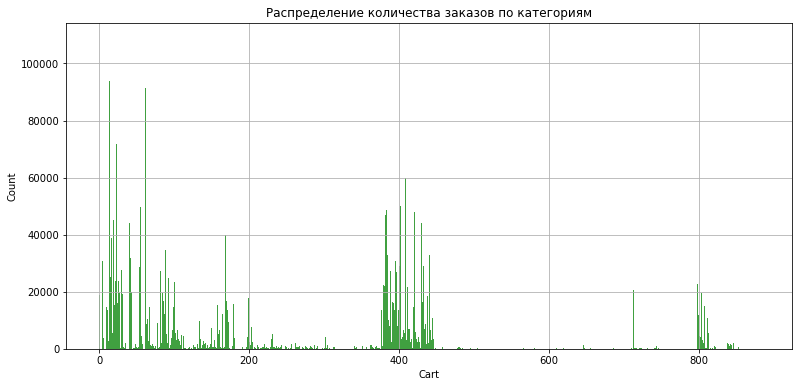

In [9]:
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 13,6

plt.hist(df['cart'], bins=len(set(carts)), facecolor='g', alpha=0.75);
plt.title('Распределение количества заказов по категориям');
plt.xlabel('Cart');
plt.ylabel('Count');
plt.grid(True)
plt.show()

# **Формирование тренировочной и тестовой выборки.**

Для каждого пользователя и кода товара заводим идентификационный номер.
Строим разряженную матрицу используя библиотеку sparse

In [23]:
data = df.copy()
data = data.loc[data['cart'].isin(carts)]
data = data.loc[data['user_id'].isin(users)]
print("Количество записей в получившемся датафрейме:", data.shape[0])
data.head()

Количество записей в получившемся датафрейме: 2395657


,user_id,order_completed_at,cart
16,3,2015-06-18 16:15:33,399
17,3,2015-07-04 14:05:22,399
18,4,2015-07-08 06:59:04,54
19,4,2015-07-08 06:59:04,55
20,5,2015-07-22 08:16:24,409


In [25]:
data['id_user_id'] = data['user_id'].astype("category").cat.codes
data['id_items'] = data['cart'].astype("category").cat.codes

In [26]:
data.head()

,user_id,order_completed_at,cart,id_user_id,id_items
16,3,2015-06-18 16:15:33,399,2,394
17,3,2015-07-04 14:05:22,399,2,394
18,4,2015-07-08 06:59:04,54,3,53
19,4,2015-07-08 06:59:04,55,3,54
20,5,2015-07-22 08:16:24,409,4,404


In [27]:
data = data.groupby(['user_id', 'cart', 'id_user_id', 'id_items'], as_index=False).order_completed_at.count()
data = data.rename({'order_completed_at':'count_in_order'}, axis='columns')

In [28]:
from sklearn.model_selection import train_test_split
train_data, test_data, = train_test_split(data, test_size = 0.2,random_state = 12)

In [29]:
def get_csr_matrix(data):
    
    users = list(set(train_data.id_user_id.unique()) | set(test_data.id_user_id.unique()))
    items = list(set(train_data.id_items.unique()) | set(test_data.id_items.unique()))

    rows = data.id_user_id.astype(int)
    cols = data.id_items.astype(int)
    
    count = list(data.count_in_order)
    
    return sparse.csr_matrix((count, (rows, cols)), shape=(len(users), len(items)))

In [30]:
sparse_train = get_csr_matrix(train_data)
sparse_test = get_csr_matrix(test_data)

In [31]:
sparse_data = get_csr_matrix(data)

In [32]:
print("Размер тренировочной выборки:", sparse_train.shape)
print("Размер тестовой выборки:", sparse_test.shape)

Размер тренировочной выборки: (13036, 858)
Размер тестовой выборки: (13036, 858)


## Modeling

Инициализируем модель. Я использовал функцию потери «WARP», которая часто обеспечивает лучший вариант производительности в библиотеке LightFM.

In [18]:
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score

In [57]:
train_score = []
test_score = []

model = LightFM(no_components=50, learning_rate=0.005, 
                loss='warp', learning_schedule='adagrad', 
                item_alpha =1e-03, user_alpha=1e-03)
epochs = 10
for epoch in range(epochs):
    model.fit_partial(sparse_train, epochs=1, num_threads=5)
    train_score.append(auc_score(model, sparse_train).mean())
    test_score.append(auc_score(model, sparse_test, train_interactions=sparse_train).mean())

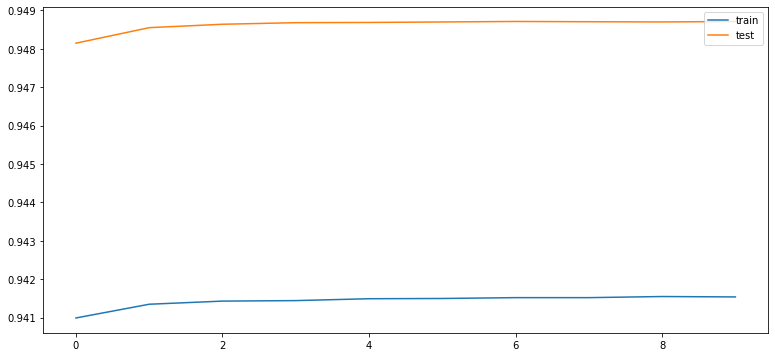

In [58]:
x = np.arange(epochs)
plt.plot(x, np.array(train_score))
plt.plot(x, np.array(test_score))
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [59]:
train_precision = precision_at_k(model, sparse_train, k=5).mean()
test_precision = precision_at_k(model, sparse_test, k=5).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))

Precision: train 0.65, test 0.16.


In [323]:
model.fit_partial(sparse_data, epochs=60, num_threads=4)
precision_at_k(model, sparse_data).mean()

0.89152

Теперь необходимо подготовить данные сабмита для передачи их в модель и получение предсказаний. 

In [308]:
# Создаем словари пользователей и категорий

from tqdm import tqdm_notebook

model.fit_partial(sparse_data, epochs=40, num_threads=4,) 

for index, (user, cart) in tqdm_notebook(enumerate(zip(users,carts))):
    
    scores = model.predict(user_ids = np.array([user]), item_ids = np.array([cart]))
    
    if scores[0] < 0.5:
        submit_df['target'][index] = 0
    else:
        submit_df['target'][index] = 1

0it [00:00, ?it/s]

In [309]:
submit_df

,id,target
0,0;133,0
1,0;5,0
2,0;10,0
3,0;396,0
4,0;14,1
...,...,...
790444,19998;26,1
790445,19998;31,1
790446,19998;29,1
790447,19998;798,1


In [310]:
submit_df.to_csv('submit.csv', sep=',', index=False)